In [1]:
# загрузим необходимые библиотеки

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок
np.set_printoptions(suppress=True) # отключаем научную нотацию
color = sns.color_palette()

In [66]:
import os
path = os.getcwd()

In [68]:
os.listdir(
path + '\data')

['HW_test_additional_data.csv',
 'HW_test_main_data.csv',
 'HW_train_additional_data.csv',
 'HW_train_main_data.csv']

In [4]:
#Cчитаем данные в соответствующие датафреймы
train_main_df = pd.read_csv('data/HW_train_main_data.csv')
train_additional_df = pd.read_csv('data/HW_train_additional_data.csv')
test_main_df = pd.read_csv('data/HW_test_main_data.csv')
test_additional_df = pd.read_csv('data/HW_test_additional_data.csv')

In [5]:
#Размер основного датасета:
train_main_df.shape

(29000, 13)

In [6]:
train_main_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,apartment condition,sub_area,price
0,30392,2014-12-30,60,36.0,6.0,9.0,1.0,1974.0,3.0,5.0,3.0,9,9711800.0
1,36540,2013-06-28,44,29.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,19,6643200.0
2,94669,2013-09-15,62,60.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,80,5698300.0
3,17531,2013-12-13,33,18.0,4.0,9.0,1.0,1970.0,1.0,6.0,2.0,15,5055000.0
4,32159,2014-02-13,37,14.0,1.0,17.0,1.0,1991.0,1.0,1.0,2.0,74,5425000.0


In [7]:
train_additional_df.head()

,id,population,indust_part,preschool_facilities,school_facilities,hospital_beds_raion,healthcare_facilities,university_num,sport_objects_facilities,additional_education_facilities,culture_objects_facilities,shopping_centers_facilities,office_num,green_part,prom_part,cafe_count,church_facilities,mosque,leisure_facilities
0,30392,155572,0.000070,5,5,240.0,1,0,7,3,0,16,1,2.86,0.00,0,0,0,0
1,36540,111874,0.089040,5,5,NaN,0,0,10,3,0,11,5,9.26,2.71,1,0,0,0
2,94669,129207,0.007720,6,6,NaN,0,0,4,2,0,4,2,13.80,0.00,4,0,0,0
3,17531,125354,0.265089,4,5,1937.0,3,0,6,4,0,2,0,7.46,0.00,1,0,0,0
4,32159,111023,0.025609,7,7,240.0,3,0,6,4,0,1,0,0.00,0.00,3,0,0,0


In [8]:
#Объединяем данные в один датасет:
train_df = train_main_df.merge(train_additional_df, how='left', on='id')
test_df = test_main_df.merge(test_additional_df, how='left', on='id')

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29000 entries, 0 to 28999
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               29000 non-null  int64  
 1   timestamp                        29000 non-null  object 
 2   full_sq                          29000 non-null  int64  
 3   life_sq                          22935 non-null  float64
 4   floor                            28843 non-null  float64
 5   max_floor                        19887 non-null  float64
 6   material                         19887 non-null  float64
 7   build_year                       16059 non-null  float64
 8   num_room                         19887 non-null  float64
 9   kitch_sq                         19887 non-null  float64
 10  apartment condition              16088 non-null  float64
 11  sub_area                         29000 non-null  int64  
 12  price             

In [10]:
#Поправим тип столбца с датами:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])

In [11]:
#Посмотрим за какой период данные:
train_df.timestamp.describe()

count                   29000
unique                   1408
top       2014-12-27 00:00:00
freq                       76
first     2011-09-06 00:00:00
last      2015-07-31 00:00:00
Name: timestamp, dtype: object

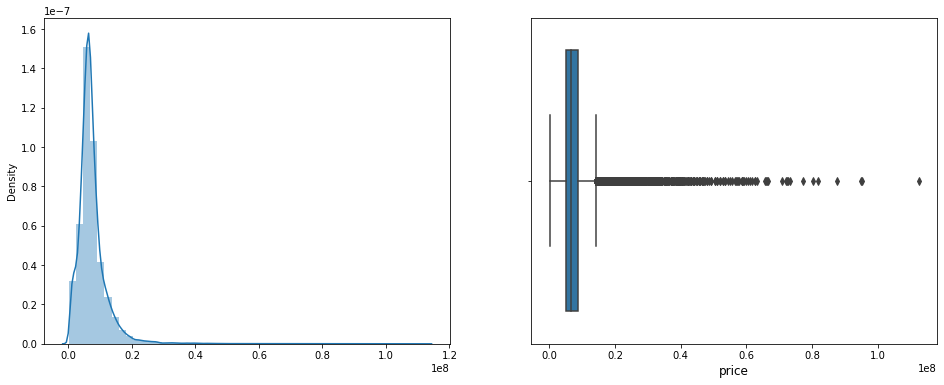

In [12]:
#Посмотрим на распределение целевой переменной:
fig, axes = plt.subplots(1,2, figsize=(16,6))
sns.distplot(train_df.price.values, bins=50, kde=True, ax=axes[0])
sns.boxplot(train_df.price.values, orient='h', ax=axes[1])
plt.xlabel('price', fontsize=12)
plt.show()



### Промежуточные выводы  
Распределение скошено вправо с длинным хвостом. Другими словами множество редких квартир в высоком ценовом диапазоне.
Есть смысл заменить длинный хвост на верхний квартиль, чтобы не портить веса модели выбросами.

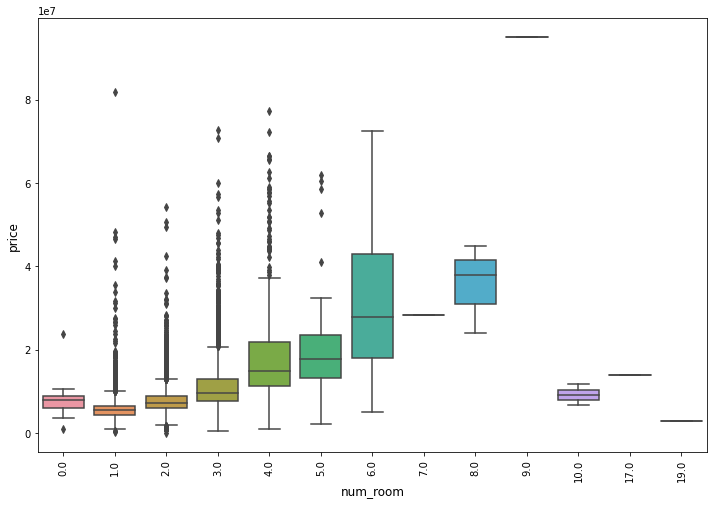

In [13]:
# Рассмотрим влияние различных параметров на цену:
plt.figure(figsize=(12, 8))
sns.boxplot(x='num_room', y='price', data=train_df)
plt.ylabel('price', fontsize=12)
plt.xlabel('num_room', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

### Промежуточные выводы:  
В данных есть проблемные места: квартиры с 0 комнат и дешевые квартиры с большим количеством комнат.  
Эти строки стоит рассмотреть подробнее, возможно занулить значения.

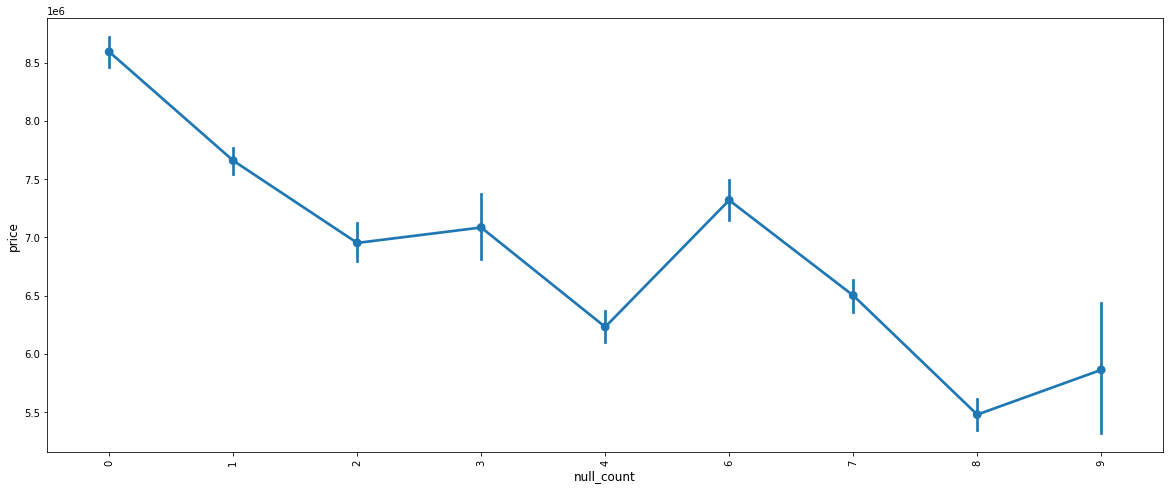

In [14]:
# Как влияет количество пропусков в строке на цену:
train_df['null_count'] = train_df.isnull().sum(axis=1)
test_df['null_count'] = test_df.isnull().sum(axis=1)


plt.figure(figsize=(20, 8))
sns.pointplot(x='null_count', y='price', data=train_df)
plt.ylabel('price', fontsize=12)
plt.xlabel('null_count', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

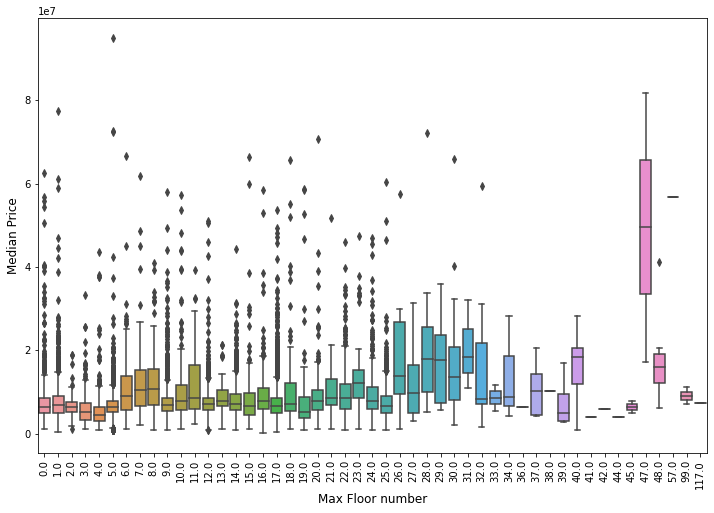

In [15]:
#Как влияет этажность здания на цену:
plt.figure(figsize=(12,8))
sns.boxplot(x="max_floor", y="price", data=train_df)
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Max Floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

### Промежуточные выводы:  
Условно можно разделить на группы: до 5 этажа включительно - дешевые пятиэтажки, от 6 до 25 этажа, от 26 до 32 этажа.  
Выброс для 4-этажного здания - максимальная цена.

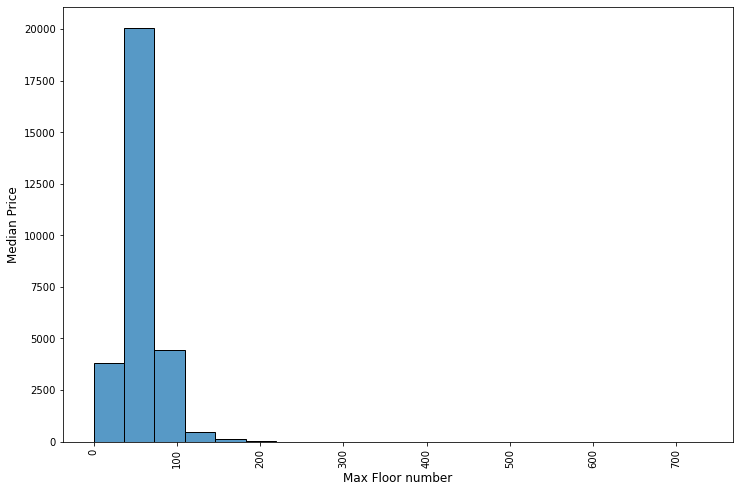

In [16]:
#Посмотрим на распределение площади до 1000:
plt.figure(figsize=(12,8))
sns.histplot(x="full_sq", data=train_df.query('full_sq<1000'), bins=20)
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Max Floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

### Промежуточные выводы:  
Основная масса в пределах 100 кв. метров, имеется множество выбросов. Есть смысл бинеризовать признак.

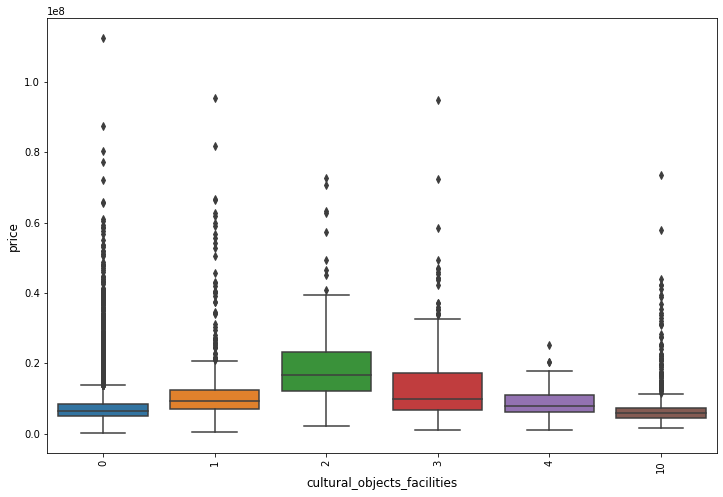

In [17]:
#Посмотрим на зависимость цены от количества окружающих культурных объектов:

plt.figure(figsize=(12, 8))
sns.boxplot(x='culture_objects_facilities', y='price', data=train_df)
plt.ylabel('price', fontsize=12)
plt.xlabel('cultural_objects_facilities', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

### Промежуточные выводы:  
Вероятно 10 культурных объектов это опечатка, скорее всего имелось в виду 0 (судя по графику).

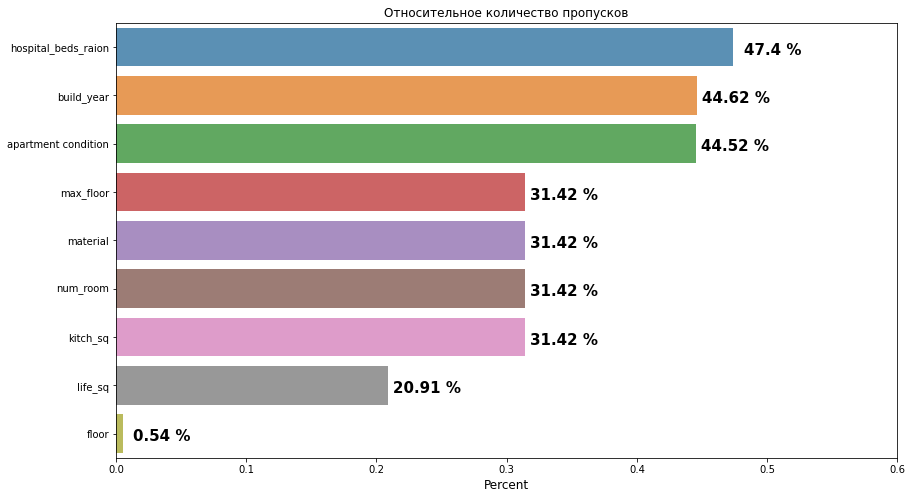

In [18]:
#Считаем процент пропусков:
per_nans = pd.DataFrame(1-train_df.count()/train_df.shape[0]).reset_index().rename({0:'percent'}, \
                                                axis=1).sort_values('percent', ascending=False).query('percent>0')
#Строим график относительного количества пропущенных значений:
fig, ax = plt.subplots(figsize = (14, 8))
bar_plot = sns.barplot(x='percent', y='index', data=per_nans, alpha=0.8, ci=None)
for ytick in bar_plot.get_yticks():
        bar_plot.text(per_nans.iloc[ytick][1]+0.03, ytick+0.15, str(round(per_nans.iloc[ytick][1]*100,2))+' %', 
                    horizontalalignment='center',size=15, color='black',weight='semibold')
plt.title('Относительное количество пропусков')
plt.ylabel('')
plt.xlabel('Percent', fontsize=12)
plt.xlim((0, 0.6))
plt.show()


### Промежуточные выводы:  
Признаков с пропусками относительно немного, первоначально попробуем не заполнять/заполнить константой. Потом, если нужно будет поэксперементируем с имплементацией.

## Data preprocessing

### Cleaning data

In [19]:
def IQR_outlier(df: pd.DataFrame, column: object, verbose: bool=True) -> tuple:
    '''
    Функция для отображения границ межквартильного размаха
    '''
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    high = perc75 + 1.5*IQR
    if verbose:
        print('25-й перцентиль: {},'.format(perc25)[:-1], '75-й перцентиль: {},'.format(perc75),
            "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=low, l=high))
    return (low, high)

In [20]:
#filtering extremal costs from target:
upper_limit = np.percentile(train_df['price'], 99)
lower_limit = np.percentile(train_df['price'], 1)

train_df.loc[(train_df['price'] > upper_limit), 'price'] = upper_limit
train_df.loc[(train_df['price'] < lower_limit), 'price'] = lower_limit

In [21]:
#brings error down a lot by removing extreme price per sqm:
train_df.loc[train_df.full_sq == 0, 'full_sq'] = 50
train_df = train_df[train_df.price/train_df.full_sq <= 600000]
train_df = train_df[train_df.price/train_df.full_sq >= 10000]

test_df.loc[test_df.full_sq == 0, 'full_sq'] = 50

In [33]:
#mistakes in life_sq:
bad_index = train_df[train_df.life_sq > train_df.full_sq].index
train_df.loc[bad_index, "life_sq"] = np.NaN
bad_index = train_df[train_df.life_sq < 5].index
train_df.loc[bad_index, "life_sq"] = np.NaN

bad_index = test_df[test_df.life_sq > test_df.full_sq].index
test_df.loc[bad_index, "life_sq"] = np.NaN
bad_index = test_df[test_df.life_sq < 5].index
test_df.loc[bad_index, "life_sq"] = np.NaN

#mistakes in full_sq:
bad_index = train_df[train_df.full_sq < 5].index
train_df.loc[bad_index, "full_sq"] = np.NaN

bad_index = test_df[test_df.full_sq < 5].index
test_df.loc[bad_index, "full_sq"] = np.NaN

#In sq has been detected date values:
kitch_is_build_year = train_df[train_df.kitch_sq.isin([1970, 1974, 2013, 2014])].index
train_df.loc[kitch_is_build_year, "build_year"] = train_df.loc[kitch_is_build_year, "kitch_sq"]

#fix invalid values from kitch_sq:
bad_index = train_df[train_df.kitch_sq >= train_df.life_sq].index
train_df.loc[bad_index, "kitch_sq"] = np.NaN
bad_index = train_df[(train_df.kitch_sq == 0).values + (train_df.kitch_sq == 1).values].index
train_df.loc[bad_index, "kitch_sq"] = np.NaN

bad_index = test_df[test_df.kitch_sq >= test_df.life_sq].index
test_df.loc[bad_index, "kitch_sq"] = np.NaN
bad_index = test_df[(test_df.kitch_sq == 0).values + (test_df.kitch_sq == 1).values].index
test_df.loc[bad_index, "kitch_sq"] = np.NaN

#fix invalid values in full_sq:
bad_index = train_df[(train_df.full_sq > 210) & (train_df.life_sq / train_df.full_sq < 0.3)].index
train_df.loc[bad_index, "full_sq"] = np.NaN

bad_index = test_df[(train_df.full_sq > 210) & (test_df.life_sq / test_df.full_sq < 0.3)].index
test_df.loc[bad_index, "full_sq"] = np.NaN

#fix invalid values in life_sq:
bad_index = train_df[train_df.life_sq > 300].index
train_df.loc[bad_index, ["life_sq", "full_sq"]] = np.NaN

bad_index = test_df[test_df.life_sq > 300].index
test_df.loc[bad_index, ["life_sq", "full_sq"]] = np.NaN

#fix invalid values in build_year:
bad_index = train_df[(train_df.build_year < 1500) & (train_df.build_year > 2016)].index
train_df.loc[bad_index, "build_year"] = np.NaN

bad_index = test_df[(test_df.build_year < 1500) & (test_df.build_year > 2016)].index
test_df.loc[bad_index, "build_year"] = np.NaN

#fix invalid room_values:
bad_index = train_df[train_df.num_room == 0].index
train_df.loc[bad_index, "num_room"] = np.NaN
bad_index = train_df[train_df.num_room.isin([10,19,17])].index
train_df.loc[bad_index, "num_room"] = np.NaN

#fix invalid floor of houses:
bad_index = train_df[(train_df.floor == 0) & (train_df.max_floor == 0)].index
train_df.loc[bad_index, ["max_floor", "floor"]] = np.NaN
bad_index = train_df[train_df.floor == 0].index
train_df.loc[bad_index, "floor"] = np.NaN
bad_index = train_df[train_df.max_floor == 0].index
train_df.loc[bad_index, "max_floor"] = np.NaN
bad_index = train_df[train_df.floor > train_df.max_floor].index
train_df.loc[bad_index, "max_floor"] = np.NaN

bad_index = test_df[(train_df.floor == 0) & (test_df.max_floor == 0)].index
test_df.loc[bad_index, ["max_floor", "floor"]] = np.NaN
bad_index = test_df[test_df.floor == 0].index
test_df.loc[bad_index, "floor"] = np.NaN
bad_index = test_df[test_df.max_floor == 0].index
test_df.loc[bad_index, "max_floor"] = np.NaN
bad_index = test_df[test_df.floor > test_df.max_floor].index
test_df.loc[bad_index, "max_floor"] = np.NaN

#fix invalid build_year:
train_df.build_year = train_df.build_year.replace(20052009, 2009)
bad_index = train_df[(train_df.build_year <=950) | (train_df.build_year >= 2020)].index
train_df.loc[bad_index, "build_year"] = np.NaN

bad_index = test_df[(test_df.build_year <= 950) | (test_df.build_year >= 2020)].index
test_df.loc[bad_index, "build_year"] = np.NaN

In [34]:
train_df.build_year.unique()

array([1974.,   nan, 1970., 1991., 2014., 1997., 1971., 1992., 2002.,
       2008., 1963., 1977., 1964., 2001., 1926., 1979., 1969., 1993.,
       2003., 1975., 1989., 2015., 1998., 1956., 2016., 1983., 1973.,
       1966., 1980., 2009., 2010., 1994., 2013., 1962., 1958., 1981.,
       1999., 2005., 1959., 2006., 1987., 1961., 1967., 1957., 1976.,
       1984., 1965., 1982., 1954., 1995., 1990., 2011., 2000., 1912.,
       1986., 1931., 1996., 1917., 2012., 1932., 2004., 2007., 1968.,
       1988., 1972., 1951., 1978., 2017., 1960., 1955., 1940., 1952.,
       1928., 1937., 1934., 1985., 1915., 1936., 1947., 1935., 1953.,
       1927., 1939., 1910., 1930., 1943., 1929., 1914., 1890., 1907.,
       1950., 1949., 1938., 1920., 1946., 1924., 1933., 1906., 1896.,
       1904., 2018., 1876., 1895., 1925., 1900., 1860., 1948., 1911.,
       1941., 1691., 1886.])

### Feature engenering

In [35]:
#Добавим дополнительные столбцы на основе имеющейся даты:

# get year
train_df['year'] = train_df.timestamp.dt.year
test_df['year'] = test_df.timestamp.dt.year

# get month of year
train_df['month'] = train_df.timestamp.dt.month
test_df['month'] = test_df.timestamp.dt.month

# get day of week
train_df['week_of_year'] = train_df.timestamp.dt.weekofyear
test_df['week_of_year'] = test_df.timestamp.dt.weekofyear

# get week of the year
train_df['day_of_week'] = train_df.timestamp.dt.weekday
test_df['day_of_week'] = test_df.timestamp.dt.weekday

# создадим столбец для месяца года:
train_df['year_month'] = (train_df.timestamp.dt.month + train_df.timestamp.dt.year * 100)
train_df['year_week'] = (train_df.timestamp.dt.weekofyear + train_df.timestamp.dt.year * 100)

# создадим столбец для месяца года:
test_df['year_month'] = (test_df.timestamp.dt.month + test_df.timestamp.dt.year * 100)
test_df['year_week'] = (test_df.timestamp.dt.weekofyear + test_df.timestamp.dt.year * 100)


In [36]:
# Биниризуем полную площадь квартиры:
bins = [0, 30, 40, 50, 60, 70, 80, 90, 100, 200, 5326]
train_df['full_sq_bins'] = np.searchsorted(bins, train_df.full_sq.values)

bins = [0, 30, 40, 50, 60, 70, 80, 90, 100, 200, 5326]
test_df['full_sq_bins'] = np.searchsorted(bins, test_df.full_sq.values)

In [37]:
# Добавим количество объектов по временным меткам:

# Add month-year
month_year_cnt_map = train_df.year_month.value_counts().to_dict()
train_df['month_year_cnt'] = train_df.year_month.map(month_year_cnt_map)

month_year_cnt_map = test_df.year_month.value_counts().to_dict()
test_df['month_year_cnt'] = test_df.year_month.map(month_year_cnt_map)

# Add week-year count
week_year_cnt_map = test_df.year_week.value_counts().to_dict()
test_df['week_year_cnt'] = test_df.year_week.map(week_year_cnt_map)

week_year_cnt_map = test_df.year_week.value_counts().to_dict()
test_df['week_year_cnt'] = test_df.year_week.map(week_year_cnt_map)

In [38]:
# Добавим некоторые другие признаки:

# ratio of living area to full area
train_df["ratio_life_sq_full_sq"] = train_df["life_sq"] / np.maximum(train_df["full_sq"].astype("float"), 1)
test_df["ratio_life_sq_full_sq"] = test_df["life_sq"] / np.maximum(test_df["full_sq"].astype("float"),1)

train_df.loc[(train_df["ratio_life_sq_full_sq"] < 0), "ratio_life_sq_full_sq"] = 0
train_df.loc[(train_df["ratio_life_sq_full_sq"] > 1), "ratio_life_sq_full_sq"] = 1

test_df.loc[(test_df["ratio_life_sq_full_sq"] < 0), "ratio_life_sq_full_sq"] = 0
test_df.loc[(test_df["ratio_life_sq_full_sq"] > 1), "ratio_life_sq_full_sq"] = 1

# ratio of kitchen area to living area 
train_df["ratio_kitch_sq_life_sq"] = train_df["kitch_sq"] / np.maximum(train_df["life_sq"].astype("float"),1)
test_df["ratio_kitch_sq_life_sq"] = test_df["kitch_sq"] / np.maximum(test_df["life_sq"].astype("float"),1)

train_df.loc[(train_df["ratio_kitch_sq_life_sq"] < 0), "ratio_kitch_sq_life_sq"] = 0
train_df.loc[(train_df["ratio_kitch_sq_life_sq"] > 1), "ratio_kitch_sq_life_sq"] = 1

test_df.loc[(test_df["ratio_kitch_sq_life_sq"] < 0), "ratio_kitch_sq_life_sq"] = 0
test_df.loc[(test_df["ratio_kitch_sq_life_sq"] > 1), "ratio_kitch_sq_life_sq"] = 1

# ratio of kitchen area to full area #
train_df["ratio_kitch_sq_full_sq"] = train_df["kitch_sq"] / np.maximum(train_df["full_sq"].astype("float"),1)
test_df["ratio_kitch_sq_full_sq"] = test_df["kitch_sq"] / np.maximum(test_df["full_sq"].astype("float"),1)

train_df.loc[(train_df["ratio_kitch_sq_full_sq"] < 0), "ratio_kitch_sq_full_sq"] = 0
train_df.loc[(train_df["ratio_kitch_sq_full_sq"] > 1), "ratio_kitch_sq_full_sq"] = 1

test_df.loc[(test_df["ratio_kitch_sq_full_sq"] < 0), "ratio_kitch_sq_full_sq"] = 0
test_df.loc[(test_df["ratio_kitch_sq_full_sq"] > 1), "ratio_kitch_sq_full_sq"] = 1

# floor of the house to the total number of floors in the house 
train_df["ratio_floor_max_floor"] = train_df["floor"] / train_df["max_floor"].astype("float")
test_df["ratio_floor_max_floor"] = test_df["floor"] / test_df["max_floor"].astype("float")

# calculate room_size
train_df['room_size'] = train_df['life_sq'] / train_df['num_room'].astype(float)
test_df['room_size'] = test_df['life_sq'] / test_df['num_room'].astype(float)

### Input missing values

In [52]:
#Заполним пропуски константой вне шкалы:
train_df = train_df.fillna(-9999) 
test_df = test_df.fillna(-9999)

### Modeling

In [53]:
#Задаем гиперпараметры модели:
xgb_params = {
        'eta': 0.05,
        'max_depth': 5,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'silent': 1
             }

In [54]:
#Делим на train/test выборки (out_of_time):
train_X = train_df[train_df.timestamp < pd.to_datetime('2015-05-01')].drop(['id', 'timestamp', 'price'], axis=1)
train_y = train_df[train_df.timestamp < pd.to_datetime('2015-05-01')].price
val_X = train_df[train_df.timestamp >= pd.to_datetime('2015-05-01')].drop(['id','price','timestamp'], axis=1)
val_y = train_df[train_df.timestamp >= pd.to_datetime('2015-05-01')].price

In [56]:
col_list = train_X.columns

In [57]:
xgb_train = xgb.DMatrix(train_X[col_list], train_y, feature_names = col_list, enable_categorical=True)
xgb_test = xgb.DMatrix(val_X[col_list], val_y, feature_names = col_list, enable_categorical=True)

In [58]:
evallist = [ (xgb_train, 'train'), (xgb_test, 'eval')]

In [59]:
#Скорим на тесте:
model = xgb.train(params = xgb_params,
                  dtrain = xgb_train, 
                  num_boost_round = 300, 
                  evals = evallist, 
                  early_stopping_rounds = 10, 
                  verbose_eval = 10)

[17:33:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[17:33:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:8022675.00000	eval-rmse:9168881.00000
[10]	train-rmse:5261511.50000	eval-rmse:6183182.50000
[20]	train-rmse:3781171.75000	eval-rmse:4522934.50000
[30]	train-rmse:3026350.50000	eval-rmse:3620483.50000
[40]	train-rmse:2669634.00000	eval-rmse:3142093.00000
[50]	train-rmse:2501434.25000	eval-rmse:2895343.75000
[60]	train-rmse:2416111.25000	eval-rmse:2765525.75000
[70]	train-rmse:2364458.50000	eval-rmse:2674689.00000
[80]	t

In [358]:
#Функция отрисовки важности фичей:
def draw_feature_importances(clf, top_k=10):
    '''
    Отрисовка важности переменных
    '''
    plt.figure(figsize=(10, 10))
    
    importances = dict(sorted(clf.get_score().items(), key=lambda x: x[1])[-top_k:])
    y_pos = np.arange(len(importances))
    
    plt.barh(y_pos, list(importances.values()), align='center', color='green')
    plt.yticks(y_pos, importances.keys(), fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel('Feature importance', fontsize=15)
    plt.title('Features importances, Sberbank Gender Prediction', fontsize=18)
    plt.ylim(-0.5, len(importances) - 0.5)
    plt.show()

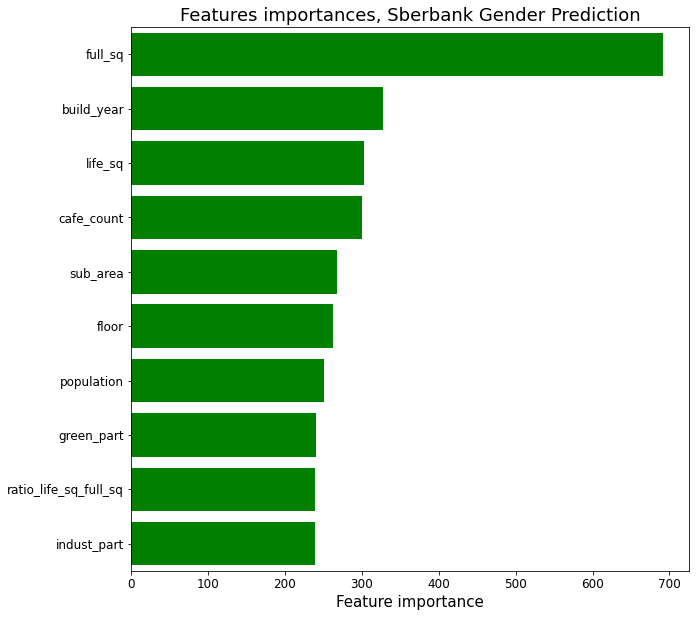

In [359]:
#Отрисовка важности фичей:
draw_feature_importances(model, 10)

### Prediction

In [60]:
#Убираем лишнее:
train_X = train_df.drop(['id', 'timestamp', 'price'], axis=1)
train_y = train_df.price
test_X = test_df.drop(['id', 'timestamp'], axis=1)


In [61]:
#Формируем выборки для модели:
xgb_train = xgb.DMatrix(train_X[col_list], train_y, feature_names = col_list, enable_categorical=True)
xgb_test = xgb.DMatrix(test_X[col_list], feature_names=col_list)

In [62]:
#Обучаем модель на всех данных:
model = xgb.train(params = xgb_params,
                  dtrain = xgb_train, 
                  num_boost_round = 1000)

[17:33:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[17:33:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [63]:
#Формируем вектор предсказаний:
y_pred = model.predict(xgb_test)

In [65]:
#Запишем файл с предсказанием:
pd.DataFrame({'id': test_df.id,
              'predicted_price': y_pred}).to_csv('prediction_csv', index=False)